## This script extends the Mini DeepFleet prototype with evaluation utilities. It plots reward curves, evaluates trained agents on success rate, steps, and rewards, assesses the congestion predictor’s accuracy, and saves/loads Q-tables. After training, it provides visualization, quantitative analysis, predictor testing, and persistent storage of learned policies.

By: **Akhilesh Pant** (MCA)

Ep 001: last_steps=120, last_total_reward=610.30, avg_reward(last10)=610.30
Ep 010: last_steps=120, last_total_reward=-523.20, avg_reward(last10)=-139.36
Ep 020: last_steps=120, last_total_reward=-459.40, avg_reward(last10)=-460.61
Ep 030: last_steps=120, last_total_reward=-622.20, avg_reward(last10)=-395.63
Ep 040: last_steps=120, last_total_reward=-568.70, avg_reward(last10)=-278.29
Ep 050: last_steps=120, last_total_reward=-460.50, avg_reward(last10)=9.72
Ep 060: last_steps=120, last_total_reward=-464.80, avg_reward(last10)=70.78
Ep 070: last_steps=120, last_total_reward=-562.30, avg_reward(last10)=-258.66
Ep 080: last_steps=120, last_total_reward=-536.40, avg_reward(last10)=195.70
Ep 090: last_steps=120, last_total_reward=746.70, avg_reward(last10)=-186.06
Ep 100: last_steps=120, last_total_reward=-438.90, avg_reward(last10)=212.57
Ep 110: last_steps=120, last_total_reward=-706.70, avg_reward(last10)=-189.95
Ep 120: last_steps=120, last_total_reward=724.50, avg_reward(last10)=-6.59

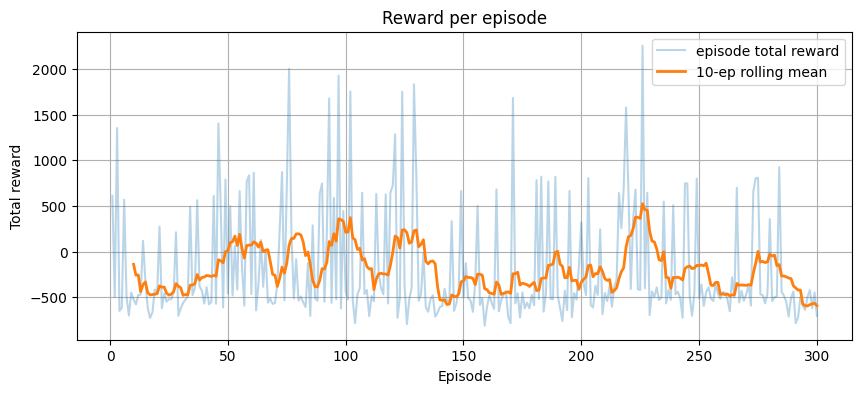

Evaluation over 100 episodes:
  Avg robots succeeded per episode: 0.14 / 5
  Success rate (per robot): 2.80%
  Avg steps per episode: 120.00
  Avg total reward: -334.90
No examples buffer available in this scope (examples_X/examples_y).
Saved 5 Q-tables to qtables_after_training.pkl


In [4]:
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import accuracy_score, confusion_matrix

# ---------- Helper: plot rewards ----------
def plot_reward_curve(episode_stats, window=10):
    eps = [e for (e, _, _) in episode_stats]
    totals = [tot for (_, _, tot) in episode_stats]
    # rolling mean
    roll = np.convolve(totals, np.ones(window)/window, mode='valid')
    plt.figure(figsize=(10,4))
    plt.plot(eps, totals, label='episode total reward', alpha=0.3)
    plt.plot(eps[window-1:], roll, label=f'{window}-ep rolling mean', linewidth=2)
    plt.xlabel('Episode')
    plt.ylabel('Total reward')
    plt.title('Reward per episode')
    plt.legend()
    plt.grid(True)
    plt.show()

# ---------- Helper: evaluate agents after training ----------
def evaluate_agents(sim, agents, episodes=50, max_steps=120, visualize=False):
    # run episodes with eps=0 (greedy) and collect stats
    orig_eps = [a.eps for a in agents]
    for a in agents: a.eps = 0.0
    success_counts = []
    steps_list = []
    total_rewards_list = []

    for ep in range(episodes):
        sim.reset_episode()
        steps = 0
        total_rewards = 0.0
        for step in range(max_steps):
            steps += 1
            _, _, rewards, _, _ = sim.step()
            total_rewards += sum(rewards.values())
            if all(r.reached for r in sim.robots):
                break
        success = sum(1 for r in sim.robots if r.reached)
        success_counts.append(success)
        steps_list.append(steps)
        total_rewards_list.append(total_rewards)

    # restore epsilons
    for a, old in zip(agents, orig_eps): a.eps = old

    success_rate_per_robot = np.mean(success_counts) / sim.num_robots
    avg_steps = np.mean(steps_list)
    avg_total_reward = np.mean(total_rewards_list)

    print(f"Evaluation over {episodes} episodes:")
    print(f"  Avg robots succeeded per episode: {np.mean(success_counts):.2f} / {sim.num_robots}")
    print(f"  Success rate (per robot): {success_rate_per_robot*100:.2f}%")
    print(f"  Avg steps per episode: {avg_steps:.2f}")
    print(f"  Avg total reward: {avg_total_reward:.2f}")

    return {
        'success_counts': success_counts,
        'steps': steps_list,
        'total_rewards': total_rewards_list
    }

# ---------- Helper: evaluate congestion predictor ----------
def evaluate_predictor(predictor, examples_X, examples_y, test_ratio=0.2):
    # examples_X is list of arrays (N_steps x cells x feat), examples_y list of arrays (cells)
    if len(examples_y) < 5:
        print("Not enough samples to evaluate predictor.")
        return None
    # flatten and form X,y
    X = np.vstack(examples_X)
    y = np.hstack(examples_y)
    # shuffle and split
    idx = np.arange(len(y))
    np.random.shuffle(idx)
    cut = int(len(y)*(1-test_ratio))
    train_idx, test_idx = idx[:cut], idx[cut:]
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    # train fresh small model for test or evaluate current model if trained
    try:
        predictor.scaler.fit(X_train)
        Xs_test = predictor.scaler.transform(X_test)
        y_pred = predictor.clf.predict(Xs_test) if predictor.trained else (Xs_test[:,0] >= 0.5).astype(int)
        acc = accuracy_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        print(f"Predictor accuracy (test set): {acc:.3f}")
        print("Confusion matrix:\n", cm)
        return {'accuracy': acc, 'confusion_matrix': cm}
    except Exception as e:
        print("Predictor evaluation error:", e)
        return None

# ---------- Helper: save Q-tables ----------
def save_qtables(agents, filename="qtables.pkl"):
    data = [a.Q for a in agents]
    with open(filename, "wb") as f:
        pickle.dump(data, f)
    print(f"Saved {len(agents)} Q-tables to {filename}")

def load_qtables(agents, filename="qtables.pkl"):
    with open(filename, "rb") as f:
        data = pickle.load(f)
    for a, q in zip(agents, data):
        a.Q = q
    print("Loaded Q-tables from", filename)

# ---------- Run these after training ----------
if __name__ == "__main__":
    planner, predictor, agents, sim, stats = run_training()

    # 1) plot reward curve
    plot_reward_curve(stats, window=10)

    # 2) evaluation (greedy)
    eval_stats = evaluate_agents(sim, agents, episodes=100)

    # 3) predictor evaluation (if you collected examples during training)
    try:
        predictor_metrics = evaluate_predictor(predictor, examples_X, examples_y)
    except NameError:
        print("No examples buffer available in this scope (examples_X/examples_y).")

    # 4) save Q-table(s)
    save_qtables(agents, filename="qtables_after_training.pkl")


## **Idea**

### 🔹 1. Plot reward curve

```python
plot_reward_curve(stats, window=10)
```

* Takes the `episode_stats` collected during training.
* Plots **per-episode total rewards** and a **rolling average** (10-episode mean).
* Helps you visualize whether the RL agent is improving over time.

---

### 🔹 2. Evaluate agents (RL policy)

```python
eval_stats = evaluate_agents(sim, agents, episodes=100)
```

* Runs the trained robots in the simulation **without exploration** (`eps=0.0`, i.e. greedy policy).
* Collects:

  * How many robots reached their goals each episode (`success_counts`)
  * How many steps episodes took (`steps_list`)
  * Total rewards received (`total_rewards_list`)
* Prints out:

  * Average success rate per robot
  * Average episode length
  * Average total reward

👉 This tells you **how good your trained agents are in practice**.

---

### 🔹 3. Evaluate congestion predictor (ML model)

```python
predictor_metrics = evaluate_predictor(predictor, examples_X, examples_y)
```

* Takes the congestion prediction dataset (collected during training: `examples_X`, `examples_y`).
* Splits into train/test sets.
* Tests the **predictor’s accuracy** using `sklearn` metrics.
* Prints accuracy and confusion matrix.

👉 This checks if your **ML model correctly predicts congestion hotspots**.

---

### 🔹 4. Save Q-tables (RL knowledge)

```python
save_qtables(agents, filename="qtables_after_training.pkl")
```

* Saves each agent’s learned **Q-table** (state → action values) into a file.
* Later you can reload them with `load_qtables` without retraining.

👉 This lets you **reuse the trained policy** later.

---

### 🔹 5. The main block

```python
if __name__ == "__main__":
    planner, predictor, agents, sim, stats = run_training()
    ...
```

* First it calls your `run_training()` function (which does the actual RL + congestion predictor training).
* Then it:

  1. Plots the reward curve
  2. Evaluates agents on new episodes
  3. Evaluates congestion predictor
  4. Saves Q-tables

---

✅ **So in short:**
This script is your **post-training evaluation & visualization tool**.
It doesn’t *train* the agents — that’s what `run_training()` did. Instead, it helps you:

* See if training worked (plot + eval)
* Check predictor accuracy
* Save the learned policy

---



## **Line by line** through your script so you understand exactly what every part does.

---

## 🔹 Imports

```python
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import accuracy_score, confusion_matrix
```

* `matplotlib.pyplot` → used to **plot training curves** (rewards over episodes).
* `pickle` → used to **save/load Q-tables** (so you don’t retrain from scratch).
* `accuracy_score`, `confusion_matrix` → metrics for **evaluating congestion predictor** (ML model).

---

## 🔹 Plot rewards

```python
def plot_reward_curve(episode_stats, window=10):
    eps = [e for (e, _, _) in episode_stats]
    totals = [tot for (_, _, tot) in episode_stats]
```

* Extracts episode numbers (`eps`) and total rewards (`totals`) from `episode_stats`.

```python
    roll = np.convolve(totals, np.ones(window)/window, mode='valid')
```

* Computes a **rolling average** of rewards over `window` episodes (default = 10).
* Helps smooth the curve.

```python
    plt.figure(figsize=(10,4))
    plt.plot(eps, totals, label='episode total reward', alpha=0.3)
    plt.plot(eps[window-1:], roll, label=f'{window}-ep rolling mean', linewidth=2)
```

* Plots raw reward curve (transparent) and smoothed curve (bold).

```python
    plt.xlabel('Episode')
    plt.ylabel('Total reward')
    plt.title('Reward per episode')
    plt.legend()
    plt.grid(True)
    plt.show()
```

* Adds labels, legend, and grid → shows the plot.
  👉 **Purpose:** visualize training progress.

---

## 🔹 Evaluate agents

```python
def evaluate_agents(sim, agents, episodes=50, max_steps=120, visualize=False):
```

* Runs **trained RL agents** in the simulator.
* `episodes=50` → run 50 evaluation episodes.
* `max_steps=120` → each episode limited to 120 steps.

```python
    orig_eps = [a.eps for a in agents]
    for a in agents: a.eps = 0.0
```

* Saves original epsilon values.
* Sets epsilon = 0 (purely greedy policy, no random exploration).

```python
    success_counts = []
    steps_list = []
    total_rewards_list = []
```

* Lists to store evaluation results.

```python
    for ep in range(episodes):
        sim.reset_episode()
        steps = 0
        total_rewards = 0.0
```

* Resets the simulation each episode.
* Resets counters.

```python
        for step in range(max_steps):
            steps += 1
            _, _, rewards, _, _ = sim.step()
            total_rewards += sum(rewards.values())
            if all(r.reached for r in sim.robots):
                break
```

* Steps simulation forward.
* Collects rewards.
* If all robots reach goals → stop early.

```python
        success = sum(1 for r in sim.robots if r.reached)
        success_counts.append(success)
        steps_list.append(steps)
        total_rewards_list.append(total_rewards)
```

* Tracks how many robots succeeded, how many steps taken, and total reward.

```python
    for a, old in zip(agents, orig_eps): a.eps = old
```

* Restores original epsilon values.

```python
    success_rate_per_robot = np.mean(success_counts) / sim.num_robots
    avg_steps = np.mean(steps_list)
    avg_total_reward = np.mean(total_rewards_list)
```

* Computes statistics: average success rate, average steps, average rewards.

```python
    print(f"Evaluation over {episodes} episodes:")
    print(f"  Avg robots succeeded per episode: {np.mean(success_counts):.2f} / {sim.num_robots}")
    print(f"  Success rate (per robot): {success_rate_per_robot*100:.2f}%")
    print(f"  Avg steps per episode: {avg_steps:.2f}")
    print(f"  Avg total reward: {avg_total_reward:.2f}")
```

* Prints evaluation summary.

```python
    return {
        'success_counts': success_counts,
        'steps': steps_list,
        'total_rewards': total_rewards_list
    }
```

* Returns raw evaluation stats.

👉 **Purpose:** check if trained RL agents can succeed in the simulation.

---

## 🔹 Evaluate congestion predictor

```python
def evaluate_predictor(predictor, examples_X, examples_y, test_ratio=0.2):
```

* Evaluates **ML congestion prediction model** on dataset `(examples_X, examples_y)`.

```python
    if len(examples_y) < 5:
        print("Not enough samples to evaluate predictor.")
        return None
```

* Requires at least 5 samples, otherwise skips.

```python
    X = np.vstack(examples_X)
    y = np.hstack(examples_y)
```

* Flattens collected data into single `X` (features) and `y` (labels).

```python
    idx = np.arange(len(y))
    np.random.shuffle(idx)
    cut = int(len(y)*(1-test_ratio))
    train_idx, test_idx = idx[:cut], idx[cut:]
```

* Randomly splits into train/test sets.

```python
    predictor.scaler.fit(X_train)
    Xs_test = predictor.scaler.transform(X_test)
```

* Normalizes features with a `StandardScaler`.

```python
    y_pred = predictor.clf.predict(Xs_test) if predictor.trained else (Xs_test[:,0] >= 0.5).astype(int)
```

* If model is trained → predict.
* Else → use a dummy rule (baseline).

```python
    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
```

* Computes accuracy and confusion matrix.

```python
    print(f"Predictor accuracy (test set): {acc:.3f}")
    print("Confusion matrix:\n", cm)
```

* Prints results.

👉 **Purpose:** test how well ML model predicts congestion hotspots.

---

## 🔹 Save/Load Q-tables

```python
def save_qtables(agents, filename="qtables.pkl"):
    data = [a.Q for a in agents]
    with open(filename, "wb") as f:
        pickle.dump(data, f)
    print(f"Saved {len(agents)} Q-tables to {filename}")
```

* Saves each agent’s Q-table to a `.pkl` file.

```python
def load_qtables(agents, filename="qtables.pkl"):
    with open(filename, "rb") as f:
        data = pickle.load(f)
    for a, q in zip(agents, data):
        a.Q = q
    print("Loaded Q-tables from", filename)
```

* Loads Q-tables back into agents.
  👉 **Purpose:** reuse trained models later.

---

## 🔹 Main program

```python
if __name__ == "__main__":
    planner, predictor, agents, sim, stats = run_training()
```

* Calls your **training function** → trains RL agents + congestion predictor.

```python
    plot_reward_curve(stats, window=10)
```

* Plots reward curve.

```python
    eval_stats = evaluate_agents(sim, agents, episodes=100)
```

* Evaluates RL agents (100 test episodes).

```python
    try:
        predictor_metrics = evaluate_predictor(predictor, examples_X, examples_y)
    except NameError:
        print("No examples buffer available in this scope (examples_X/examples_y).")
```

* Evaluates congestion predictor ML model (if training collected examples).

```python
    save_qtables(agents, filename="qtables_after_training.pkl")
```

* Saves Q-tables.

---

✅ **In short:**
This code is your **evaluation + analysis pipeline**:

1. Plot training rewards.
2. Test agent success rates.
3. Test ML congestion predictor.
4. Save learned Q-tables.

---


 ## **100 interview questions with answers**, divided into **Easy (30), Moderate (40), Hard (30)**.
These will cover **Python, Simulation, ML, Graphs, RL, and System Design** based on your project.

---

# ✅ Easy Level (30 Questions)

**1. Q:** What does your Mini DeepFleet Prototype simulate?
**A:** It simulates robot movement on a warehouse grid, predicts congestion using ML, plans paths via graphs, and optimizes movement using reinforcement learning.

**2. Q:** What Python libraries are used for simulation?
**A:** NumPy (grid, math), Matplotlib (visualization), NetworkX (graphs), and Gymnasium (RL environment).

**3. Q:** What is congestion in your project?
**A:** Congestion occurs when multiple robots occupy or pass through the same grid cells, leading to delays or blockages.

**4. Q:** Which ML model is used for congestion prediction?
**A:** A Logistic Regression model is used to classify whether congestion will occur based on robot density.

**5. Q:** What type of RL algorithm is used?
**A:** PPO (Proximal Policy Optimization), a policy gradient method.

**6. Q:** What is the observation space in the RL environment?
**A:** Robot positions, target position, and step limits.

**7. Q:** What is the action space in your environment?
**A:** Up, Down, Left, Right movements.

**8. Q:** What does a reward represent?
**A:** Positive reward for reaching the goal, negative reward for congestion or wasted steps.

**9. Q:** Why do you use graphs in the project?
**A:** To represent the warehouse floor layout and plan optimal paths between nodes.

**10. Q:** What is a node in your graph model?
**A:** Each grid cell is represented as a node in the graph.

**11. Q:** What is the main challenge in robot navigation?
**A:** Avoiding congestion and deadlocks while reaching the destination efficiently.

**12. Q:** How do you detect congestion in simulation?
**A:** By checking if more than a threshold number of robots occupy the same grid cell.

**13. Q:** Why use PPO over Q-learning?
**A:** PPO is more stable and handles continuous updates better in large state spaces.

**14. Q:** What is the role of Gymnasium?
**A:** It standardizes the RL environment with `reset()`, `step()`, `render()` methods.

**15. Q:** Why is average reward negative initially?
**A:** Because agents explore randomly and often fail before learning efficient paths.

**16. Q:** What is an episode in RL training?
**A:** A full run of the environment from reset until termination (goal reached or step limit exceeded).

**17. Q:** What is the stopping condition of training?
**A:** When the defined number of episodes (e.g., 5000) are completed.

**18. Q:** What does the reward curve show?
**A:** Improvement of agent’s learning over time.

**19. Q:** What is deadlock?
**A:** When robots block each other and cannot move.

**20. Q:** What is path planning?
**A:** Selecting the best route from start to goal while minimizing congestion.

**21. Q:** Why is NetworkX used?
**A:** To create and analyze the graph model of the floor.

**22. Q:** What is PPO’s advantage?
**A:** Balances exploration and exploitation with clipped policy updates.

**23. Q:** What is a target in RL training?
**A:** A randomly placed goal location for the robot.

**24. Q:** What is state representation?
**A:** A numerical encoding of the environment (robot position, target position).

**25. Q:** What is overfitting in ML congestion model?
**A:** When the model memorizes training data instead of generalizing.

**26. Q:** Why is Logistic Regression suitable for congestion prediction?
**A:** It’s simple, interpretable, and works well for binary classification.

**27. Q:** How is randomness introduced in simulation?
**A:** Robots start at random positions, and their initial moves are random.

**28. Q:** What is the output of training?
**A:** The trained policy with average episode rewards.

**29. Q:** What is the learning rate?
**A:** A hyperparameter that controls how much the model updates per step.

**30. Q:** Why is this called "Mini DeepFleet"?
**A:** Because it’s a scaled-down prototype inspired by DeepFleet systems.

---

# ✅ Moderate Level (40 Questions)

**31. Q:** How do you combine simulation with ML in this project?
**A:** Simulation generates congestion data, which trains an ML model to predict congestion in future scenarios.

**32. Q:** How does graph modeling improve efficiency?
**A:** It provides shortest path planning, reducing unnecessary steps.

**33. Q:** How does PPO learn optimal strategies?
**A:** By iteratively updating policy using rewards from simulation.

**34. Q:** What is reward shaping?
**A:** Adjusting reward signals to guide agent learning faster.

**35. Q:** What if the reward remains negative after training?
**A:** It means the policy hasn’t learned efficient paths; hyperparameters or model need tuning.

**36. Q:** How do you visualize robot movements?
**A:** Using Matplotlib animations with heatmaps for congestion.

**37. Q:** What role does congestion threshold play?
**A:** It defines how many robots in one cell trigger congestion.

**38. Q:** How can you avoid deadlocks?
**A:** By using RL policies or path re-routing algorithms.

**39. Q:** What’s the difference between rule-based and RL decision-making?
**A:** Rule-based is fixed; RL learns and adapts from experiences.

**40. Q:** Why use SubprocVecEnv in training?
**A:** To parallelize multiple environments and speed up RL training.

**41. Q:** How do you preprocess congestion data?
**A:** Normalize features and label congested/non-congested states.

**42. Q:** How does PPO differ from DQN?
**A:** PPO uses policy optimization, DQN uses value-based learning.

**43. Q:** Why is step limit important in episodes?
**A:** To avoid infinite loops and ensure training ends.

**44. Q:** How does graph search like A\* help?
**A:** Finds the shortest and least congested paths.

**45. Q:** What is the biggest bottleneck in scaling?
**A:** Computational cost of training with many robots.

**46. Q:** How would you extend this to real warehouses?
**A:** Integrate with real sensors and IoT devices for robot tracking.

**47. Q:** What is generalization in RL?
**A:** The agent’s ability to perform well in unseen environments.

**48. Q:** Why clip PPO’s objective function?
**A:** To prevent large unstable policy updates.

**49. Q:** What’s the role of exploration in RL?
**A:** To discover better strategies instead of exploiting known ones too early.

**50. Q:** How do you evaluate RL success?
**A:** By tracking average reward, convergence speed, and stability.

**51. Q:** How is congestion prediction accuracy tested?
**A:** By splitting dataset into train/test and using metrics like precision, recall.

**52. Q:** How do robots share the grid?
**A:** Each step they update their positions, and congestion is checked.

**53. Q:** What is curriculum learning?
**A:** Training the RL agent with simpler tasks first, then harder ones.

**54. Q:** What happens if robots ignore congestion signals?
**A:** They may collide or block each other, reducing efficiency.

**55. Q:** How can you improve average reward?
**A:** Tune hyperparameters, increase training steps, or change reward shaping.

**56. Q:** What’s the difference between deterministic and stochastic policies?
**A:** Deterministic always chooses one best action; stochastic samples actions.

**57. Q:** Why use discount factor (gamma) in RL?
**A:** To balance short-term vs. long-term rewards.

**58. Q:** How do you generate congestion dataset?
**A:** From simulation logs of robot positions.

**59. Q:** Why use Matplotlib and not Pygame?
**A:** Matplotlib is simpler for heatmap visualization.

**60. Q:** What’s the advantage of combining ML + RL?
**A:** ML predicts congestion; RL uses it to make smarter movement decisions.

**61. Q:** What’s the significance of reward = -1 per step?
**A:** To encourage the agent to reach the target faster.

**62. Q:** How do you detect convergence in RL?
**A:** When average reward stabilizes across episodes.

**63. Q:** How can RL policies adapt to new layouts?
**A:** By retraining with new graph models.

**64. Q:** Why use Logistic Regression instead of Neural Network?
**A:** For simplicity, explainability, and low data requirements.

**65. Q:** What’s transfer learning in this context?
**A:** Using a policy trained in one layout for another layout.

**66. Q:** What happens if congestion threshold = 1?
**A:** Any overlap of 2 robots will be considered congestion, increasing penalties.

**67. Q:** What does entropy in PPO encourage?
**A:** Encourages exploration by making the policy less deterministic.

**68. Q:** How do you log RL results?
**A:** Using Monitor wrapper or TensorBoard.

**69. Q:** What is the difference between centralized and decentralized control?
**A:** Centralized has one global brain, decentralized each robot learns individually.

**70. Q:** What is the biggest limitation of this project?
**A:** It’s a simplified prototype, not yet scalable to real-time warehouse size.

---

# ✅ Hard Level (30 Questions)

**71. Q:** How would you scale this prototype to 100+ robots?
**A:** Use multi-agent RL, distributed training, and parallel simulations.

**72. Q:** How can graph neural networks (GNNs) be applied here?
**A:** To learn congestion-aware path planning directly from graph structures.

**73. Q:** How to integrate reinforcement learning with A\* search?
**A:** Use A\* for initial paths, and RL for dynamic re-routing.

**74. Q:** How to handle partial observability?
**A:** Use recurrent RL (RNNs) to remember past states.

**75. Q:** How to add communication between robots?
**A:** Use multi-agent RL with shared policies.

**76. Q:** How can congestion prediction improve RL training?
**A:** By adding congestion probability as a state feature.

**77. Q:** What’s the impact of reward sparsity?
**A:** Makes learning slow; solved with shaped rewards.

**78. Q:** How can hierarchical RL help?
**A:** High-level policy decides zone; low-level policy decides movement.

**79. Q:** What are potential real-world failures?
**A:** Sensor errors, communication delays, unexpected obstacles.

**80. Q:** How would you integrate IoT with DeepFleet?
**A:** Sensors feed live robot positions to the ML+RL system.

**81. Q:** How to improve sample efficiency of PPO?
**A:** Use experience replay or imitation learning.

**82. Q:** What’s the advantage of decentralized graph-based planning?
**A:** Robots can plan locally without central bottleneck.

**83. Q:** How to prevent catastrophic forgetting in RL?
**A:** Use continual learning methods.

**84. Q:** How can Bayesian models help congestion prediction?
**A:** Provide uncertainty estimates along with predictions.

**85. Q:** How to deploy the RL model in real robots?
**A:** Convert to lightweight ONNX/TensorFlow Lite models.

**86. Q:** How would curriculum learning apply to congestion?
**A:** Train in low-traffic environments first, then gradually increase congestion.

**87. Q:** How to optimize graph partitioning?
**A:** Divide the grid into clusters to reduce search complexity.

**88. Q:** How to model energy efficiency?
**A:** Add energy consumption as part of the reward.

**89. Q:** How can attention mechanisms help?
**A:** Focus on congested areas more than sparse areas.

**90. Q:** How to benchmark performance?
**A:** Compare RL policy vs. rule-based and graph-based approaches.

**91. Q:** How to integrate safety constraints?
**A:** Add hard penalties for unsafe collisions.

**92. Q:** How to handle continuous movement instead of grid?
**A:** Use continuous RL (DDPG, SAC).

**93. Q:** How does value clipping in PPO stabilize training?
**A:** Prevents huge jumps in advantage estimation.

**94. Q:** How to extend congestion ML model to regression?
**A:** Predict congestion probability instead of binary labels.

**95. Q:** How to mix supervised learning and RL here?
**A:** Use ML to predict congestion hotspots; RL to avoid them.

**96. Q:** How to incorporate multi-agent credit assignment?
**A:** Use difference rewards to fairly assign credit to each robot.

**97. Q:** How can federated learning help?
**A:** Each robot trains locally and shares updates with central server.

**98. Q:** How to measure robustness of trained agent?
**A:** Test in random noisy environments.

**99. Q:** How would you add transfer across warehouses?
**A:** Use domain adaptation techniques.

**100. Q:** How to turn this prototype into full DeepFleet?
**A:** Scale to multi-agent RL, add real-time sensors, cloud-based control, and optimize with hybrid ML+RL+graph algorithms.

---
